## COMP47670 - Assignment 1
**Student Name: Meleesha Mayola Dsouza, Nikil Mohan**<br>
**Student Number: 18200024, 18200037**

In [1]:
# Import the required libraries
import os
import requests
import csv
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Task 1: Identifying and choosing suitable APIs

We have used API's provided by the National Basketball Association(NBA) **www.nba.com**. <br>

For the purpose of this assignment, we have used multiple API's. Because of the lack of sufficient documentation associated with the API's, the values that were required for calling the API's had to be obtained by calling another API.

The API used to collect Team ID's is : https://stats.nba.com/stats/commonTeamYears?LeagueID=00<br>
The API used to collect the required data is : https://stats.nba.com/stats/teamyearbyyearstats<br>

Using the second API, we collect data of all teams, from the time of its inception, by changing the parameters passed.

In [2]:
# Specifying the User Agent Header 
UserAgentHeaders = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36',}

### Task 2: Collect data using the chosen API(s)
A function was written to allow the calls to the API go in a particular order. These API's are called using a particular Request number that correspond to each of the API's.

The first API will return the list of teams in the NBA. We will pre-process this obtained data and use the processed data as parameters to call the other API's.

In [3]:
# This function is responsible for handling the calls to the required API  
def RequestType(RequestNum, validteams=None):
    if(RequestNum==1):
        # The first API that is called will return a list of NBA teams
        # This is required as the Team ID's will be used to build the correct parameters for the other API
        data = (requests.get('https://stats.nba.com/stats/commonTeamYears?LeagueID=00',headers=UserAgentHeaders)).json()
        return data
    if(RequestNum==2 or RequestNum==3):
        # The second API is called after getting the values from the first API
        Avgcount=0
        if(RequestNum==2):
            # This parameter will give the average values of each team over all the games in a season for all seasons in the NBA
            PermodeValue='PerGame'
        else:
            # This parameter will give the total values of each team over all the games in a season for all seasons in the NBA
            PermodeValue='Totals'
        for team_id in validteams['TEAM_ID']:
            # A loop is required as the API will be called for each valid Team ID that is returned in the first API
            AvgDetails= (requests.get('https://stats.nba.com/stats/teamyearbyyearstats?SeasonType=Regular%20Season&TeamID='+str(team_id)+'&LeagueId=00&Permode='+str(PermodeValue),headers=UserAgentHeaders)).json()
            # The CreateFile function creates the required file to store the values returned by the API calls
            CreateFile(RequestNum,AvgDetails,Avgcount)
            Avgcount=1

### Task 3: Parse the collected data and store it in an appropriate file format
Once the above function retrieves the raw data, we use the following function to parse the data that was returned in JSON format and write the data into csv.

In [4]:
def CreateFile(RequestNum, ResultRequest, Avgcount=None):
    if(RequestNum==1):
        # This file will contain the data that was returned by the 1st API call
        # The file will contain all the data i.e TeamIDs, both the valid and invalid data
        # The invalid data is the listing of TeamIDs which do not exist
        # The data from this file will be cleaned before performing any calculations
        Requested_data = open('./TeamIDData.csv', 'w+',newline='')
        IDwriter = csv.writer(Requested_data)
        count = 0
        # We need to write the column names in the 1st row of the csv file
        # The column names are in the 'headers' key of the json result
        if count == 0:
            header = ResultRequest['resultSets'][0]['headers']
            IDwriter.writerow(header)
            count += 1
        for entries in ResultRequest['resultSets'][0]['rowSet']:
              IDwriter.writerow(entries)    
        Requested_data.close()        
    if(RequestNum==2 or RequestNum==3):
        # These files will contain the data that was returned by variations to the 2nd API call
        # The files have 33 columns out of which only a few will be used
        # The files also contains invalid data. The data from this file will be cleaned before doing any calculations
        if(RequestNum==2):
            # This file will contain the average of the stats of each team over the years
            Requested_data = open('./AvgTeamData.csv', 'a',newline='')
        else:
            # This file will contain the total value of the stats of each team over the years
            Requested_data = open('./TotalTeamData.csv', 'a',newline='')
        AVGwriter = csv.writer(Requested_data)
        # We need to write the headings in the 1st row of the csv file
        # The heading names are in the 'headers' key of the json result
        if Avgcount == 0:
            header = ResultRequest['resultSets'][0]['headers']
            AVGwriter.writerow(header)
            Avgcount = 1
        for teamAvg in ResultRequest['resultSets'][0]['rowSet']:
            AVGwriter.writerow(teamAvg)    
        Requested_data.close()

### Task 4: Load, Represent and Pre-Process the Data
There is a lot of data that is obtained from the API calls. It represents the data related to each of the 30 teams in the NBA, right from the time of creation of that team.<br>

#### Combining the data
The 1st API is called only once.<br>
The 2nd API is called 30 times to get the average stats for each team. It is again called 30 times to get the cumulative stats for each team.<br>(So a total of 1 + 30 + 30 = 61 calls to API's).<br>
A total of 3 files were created:<br>
1st file for the list of teams.<br>
2nd file for the average stats of each team over the years per season.<br>
3rd file for the cumulative stats of each team over the years per season.

In [5]:
# We use the variable OrderofExecution to specify the order of the API calls
# Before calling the API, we will check if the data file is already present. If present, we need not call the API
# Following the order of execution specified above, we initally call the 1st API and then increment the OrderofExecution
OrderofExecution = 1
if(os.path.isfile('./TeamIDData.csv'))==False:
    ResultRequest = RequestType(OrderofExecution)
    CreateFile(OrderofExecution,ResultRequest)
OrderofExecution += 1
# The TeamIDDataFrame is created from the csv file and it contains invalid data
# The invalid data are essentially extra rows which do not correspond to any particular teams but still have a TeamID
# These extra TeamID's are created by the NBA for the purpose of integrating expansion teams
TeamIDDataFrame = pd.read_csv("TeamIDData.csv")
ValidTeams = TeamIDDataFrame[TeamIDDataFrame['ABBREVIATION'].notnull()]
# Once we have extracted the valid TeamID's, we can now call the 2nd API to get the stats
if(os.path.isfile('./AvgTeamData.csv'))==False:
    RequestType(OrderofExecution, ValidTeams)
OrderofExecution += 1
# We can now call the 3rd API to get the stats of each team
if(os.path.isfile('./TotalTeamData.csv'))==False:
    RequestType(OrderofExecution, ValidTeams)

In [6]:
# The list of valid teams (after removing the invalid teams) that we have obtained from the Team list
ValidTeams

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION
0,0,1610612737,1949,2018,ATL
1,0,1610612738,1946,2018,BOS
2,0,1610612739,1970,2018,CLE
3,0,1610612740,2002,2018,NOP
4,0,1610612741,1966,2018,CHI
5,0,1610612742,1980,2018,DAL
6,0,1610612743,1976,2018,DEN
7,0,1610612744,1946,2018,GSW
8,0,1610612745,1967,2018,HOU
9,0,1610612746,1970,2018,LAC


The data that we obtain from the 2nd and 3rd API contains a lot of missing data.<br>
There are two reasons why the data is missing for earlier years:<br>
Reason 1: The NBA did not track the data for 2 pointer attempts until the 1980's.<br>
Reason 2: The 3 point line was only introduced during the 1979-1980 season in the NBA.

#### Filtering the data
To eliminate the missing data, we will only consider the data from the 1982-1983 season.<br>
However, we do not have a column that specifies the beginning of the season as an Integer.<br>
We have created a new column called 'SEASON_BEGIN' based on the season/year column for our analysis.

In [7]:
# The AverageStatsDataFrame is created from the csv file
# There is some manipulation required for our analysis
AverageStatsDataFrame= pd.read_csv("AvgTeamData.csv")
# Displaying only the first few entries
AverageStatsDataFrame.head(5)

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612737,Tri-Cities,Blackhawks,1949-50,64,29,35,0.453,0,3,...,0.0,0.0,0.0,20.8,32.1,0.0,0.0,0.0,83.0,5
1,1610612737,Tri-Cities,Blackhawks,1950-51,68,25,43,0.368,0,5,...,0.0,0.0,0.0,21.7,30.8,0.0,0.0,0.0,84.3,6
2,1610612737,Milwaukee,Hawks,1951-52,66,17,49,0.258,0,5,...,0.0,0.0,0.0,18.6,28.0,0.0,0.0,0.0,73.2,10
3,1610612737,Milwaukee,Hawks,1952-53,71,27,44,0.380,0,5,...,0.0,0.0,0.0,20.1,29.9,0.0,0.0,0.0,75.9,9
4,1610612737,Milwaukee,Hawks,1953-54,72,21,51,0.292,0,4,...,0.0,0.0,0.0,18.0,24.6,0.0,0.0,0.0,70.0,9


In [8]:
# The TotalStatsDataFrame is created from the csv file 
# There is some manipulation required for our analysis
TotalStatsDataFrame= pd.read_csv("TotalTeamData.csv")
# Displaying only the first few entries
TotalStatsDataFrame.head(5)

,TEAM_ID,TEAM_CITY,TEAM_NAME,YEAR,GP,WINS,LOSSES,WIN_PCT,CONF_RANK,DIV_RANK,...,OREB,DREB,REB,AST,PF,STL,TOV,BLK,PTS,PTS_RANK
0,1610612737,Tri-Cities,Blackhawks,1949-50,64,29,35,0.453,0,3,...,0,0,0,1330,2057,0,0,0,5313,10
1,1610612737,Tri-Cities,Blackhawks,1950-51,68,25,43,0.368,0,5,...,0,0,0,1476,2092,0,0,0,5730,3
2,1610612737,Milwaukee,Hawks,1951-52,66,17,49,0.258,0,5,...,0,0,0,1229,1848,0,0,0,4833,10
3,1610612737,Milwaukee,Hawks,1952-53,71,27,44,0.380,0,5,...,0,0,0,1427,2120,0,0,0,5389,9
4,1610612737,Milwaukee,Hawks,1953-54,72,21,51,0.292,0,4,...,0,0,0,1298,1771,0,0,0,5038,9


In [9]:
# The creation of the new column for the purpose of our analysis by splitting the YEAR column
AverageStatsDataFrame['SEASON_BEGIN']=AverageStatsDataFrame['YEAR'].str.split('-',expand=True)[0]
TotalStatsDataFrame['SEASON_BEGIN']=TotalStatsDataFrame['YEAR'].str.split('-',expand=True)[0]
# Considering only seasons from 1982 to handle missing values
ProcessedAvgStatsDataFrame = AverageStatsDataFrame[AverageStatsDataFrame['SEASON_BEGIN']>=str(1982)]
ProcessedTotalStatsDataFrame = TotalStatsDataFrame[TotalStatsDataFrame['SEASON_BEGIN']>=str(1982)]
# Our focus of this analysis are the data related to 2 pointers and the 3 pointers in both the dataframes
# Averaging the performance of the entire league instead of each teams performance since 1982
LeagueAverage = ProcessedAvgStatsDataFrame.groupby(['YEAR'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT'].mean()
# Finding the cumulative stats of the performance of the entire league instead of each teams performance since 1979
LeagueTotal = ProcessedTotalStatsDataFrame.groupby(['YEAR'])['FGM','FGA','FG_PCT','FG3M','FG3A','FG3_PCT'].mean()

In [10]:
# Displaying a few entries in the LeagueAverage Dataframe
LeagueAverage.head(5)

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT
YEAR,,,,,,
1982-83,43.530435,89.656522,0.485478,0.534783,2.252174,0.230826
1983-84,43.486957,88.356522,0.491957,0.595652,2.373913,0.242174
1984-85,43.765217,89.095652,0.491217,0.891304,3.143478,0.273652
1985-86,43.195652,88.634783,0.487261,0.947826,3.339130,0.268261
1986-87,42.643478,88.795652,0.480478,1.421739,4.734783,0.290217


In [11]:
# Displaying a few entries in the LeagueTotal Dataframe
LeagueTotal.head(5)

,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT
YEAR,,,,,,
1982-83,3569.000000,7352.086957,0.485478,43.956522,184.695652,0.230826
1983-84,3565.521739,7245.130435,0.491957,48.695652,194.956522,0.242174
1984-85,3588.347826,7306.478261,0.491217,72.652174,257.260870,0.273652
1985-86,3541.956522,7268.086957,0.487261,77.130435,273.608696,0.268261
1986-87,3496.608696,7280.652174,0.480478,116.826087,387.521739,0.290217


In [12]:
# Resetting the index of the DataFrames and using the default ones instead
LeagueAverage.reset_index(inplace=True)
LeagueTotal.reset_index(inplace=True)

### Task 5: Analysing and summarising the data
Using the cleaned and processed the data, we will create visualizations for analysis

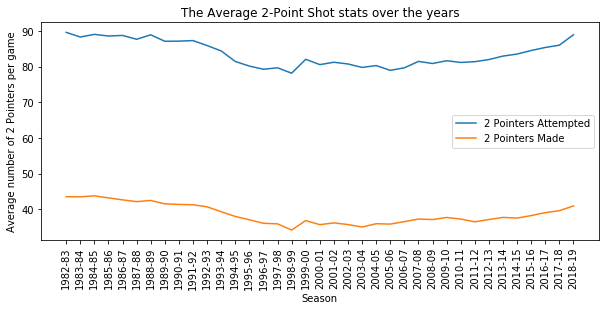

In [13]:
# Plotting the number of 2-Point attempts and makes over the years
plt.figure(figsize=(10,4))
plt.plot(LeagueAverage['YEAR'], LeagueAverage[['FGA','FGM']])
plt.title("The Average 2-Point Shot stats over the years")
plt.xlabel("Season")
plt.ylabel("Average number of 2 Pointers per game")
plt.xticks(rotation=90)
plt.legend(('2 Pointers Attempted','2 Pointers Made'), loc=7)
plt.show()

We can observe from the graph above that the number of 2 pointers made and attempted remain almost same. The values hover around 45 2-Pointers made and 90 2-Pointers attempted over the years.

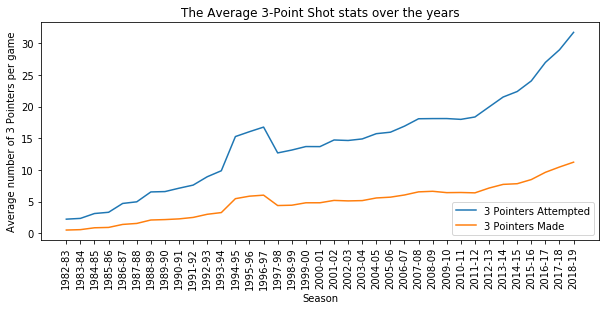

In [14]:
# Plotting the number of 3-Point attempts and makes over the years
plt.figure(figsize=(10,4))
plt.plot(LeagueAverage['YEAR'], LeagueAverage[['FG3A','FG3M']])
plt.title("The Average 3-Point Shot stats over the years")
plt.xlabel("Season")
plt.ylabel("Average number of 3 Pointers per game")
plt.xticks(rotation=90)
plt.legend(('3 Pointers Attempted','3 Pointers Made'), loc=4)
plt.show()

From the graph above, we can see that there has been a drastic increase in the number of 3-Pointers attempted and made per game over the years. The number of 3-Point attempts was less than 5 per team in the early 1980's. However, the number of 3-Pointer attempts per game exceeded over 30 this year(2018-19), despite more games left to be played in the current season.

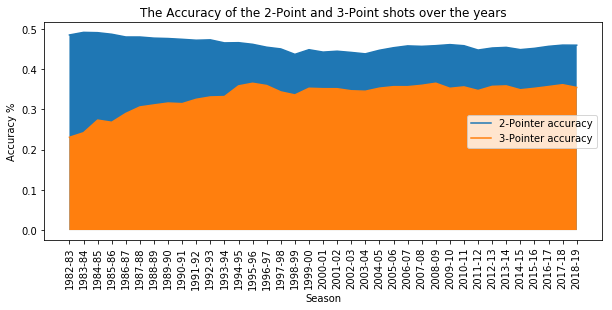

In [15]:
# Plotting the accuracy with which the NBA players are making the 2-Pointers and 3-Pointers
plt.figure(figsize=(10,4))
plt.plot(LeagueTotal['YEAR'], LeagueTotal[['FG_PCT','FG3_PCT']])
plt.fill_between(LeagueAverage['YEAR'], LeagueAverage['FG_PCT'])
plt.fill_between(LeagueAverage['YEAR'], LeagueAverage['FG3_PCT'])
plt.title("The Accuracy of the 2-Point and 3-Point shots over the years")
plt.xlabel("Season")
plt.ylabel("Accuracy %")
plt.xticks(rotation=90)
plt.legend(('2-Pointer accuracy','3-Pointer accuracy'), loc=7)
plt.show()

We can observe that the accuracy of the 2-Point shot has slightly decreased over the years by 2% or 3%. 

However, the most drastic change can be seen with the accuracy of the 3-Point shot. When the 3-Point shot was introduced, it was seen as more of a novelty feature than an effective playmaking decision. The general thought was that the farther away the shot is taken from (like the 3 pointer when compared to the 2 pointer), the worse shot it is. But the graph shows a very large increase in the accuracy of the 3-Point shot. We can generally say that, currently, there is only a 10% difference between accuracy of the 3-Point shot when compared to a 2-Point shot.


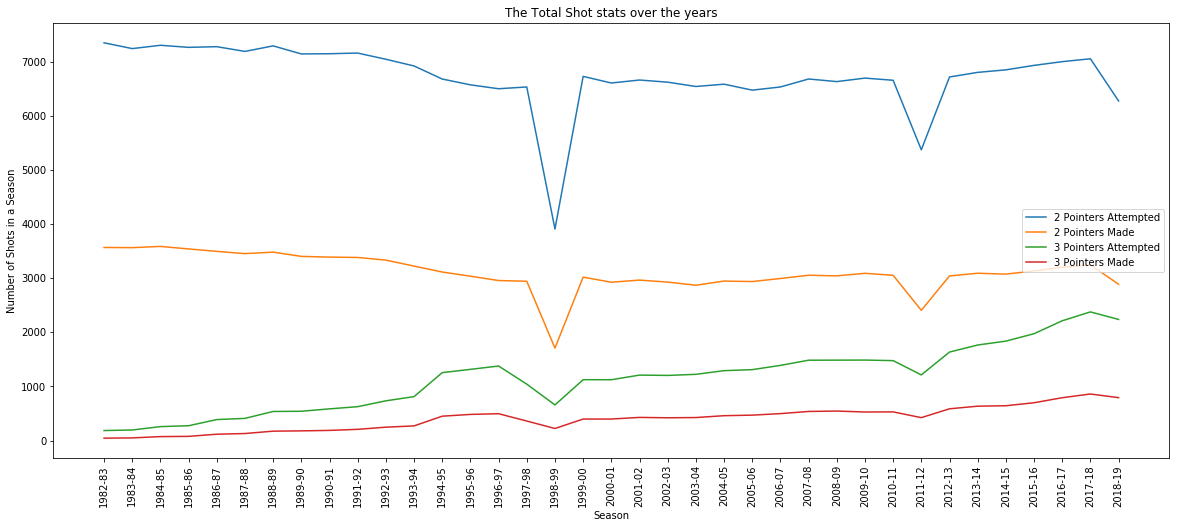

In [16]:
# To get a true picture of the volume of shots (both 2-Pointers and 3-Pointers), the below graph has been plotted
plt.figure(figsize=(20,8))
plt.plot(LeagueTotal['YEAR'], LeagueTotal[['FGA','FGM','FG3A','FG3M']])
plt.title("The Total Shot stats over the years")
plt.xlabel("Season")
plt.ylabel("Number of Shots in a Season")
plt.xticks(rotation=90)
plt.legend(('2 Pointers Attempted','2 Pointers Made','3 Pointers Attempted','3 Pointers Made'), loc=7)
plt.show()

One anomaly that is observable in the graph is evident in the 1998-99 season and the 2011-12 season. The total stats for these seasons are lower because of these seasons being the NBA lockout shortened seasons, i.e. Number of games were reduced from 82 games to 50 and 66 games respectively.

### Final Analysis
Observing the graph, we can see that the stats related to the 2-Point attempts have been generally the same. This is in stark contrast to the stats of the 3-Pointers. The total number of 3-Point attempts of all teams in the earlier seasons were around the 200 shots. Now, however, the number of 3-Pointers have increased more than 10-fold. Teams are prioritizing the value of 3-Pointers and no longer see it as a gimmick.<br>

Another deduction from the visualizations is that the pace of an NBA game has drastically increased. Given the fixed amount of time in an NBA game, the number of 2-Pointers have remained fairly the same but the number of 3-Pointers have drastically increased. Thereby meaning, more high value shots per game than ever before.